## 🧠 Fake News using Artificial Immune Systems 

## 🔍 Problem

Fake news is a major challenge for platforms and public trust. Traditional models rely heavily on labeled datasets. But in real-world scenarios, fake content evolves rapidly — often without labels.



## 💡 Solution

Inspired by the biological immune system, this project uses the **Negative Selection Algorithm** to:

- Generate "detectors" from known **real news** articles
- Flag incoming news as **fake (non-self)** if they activate a detector
- Use **cosine distance** over semantic embeddings to measure anomaly


## 🧬 Why AIS?

Unlike supervised models, this system:
- Requires **no labeled fake data**
- Can generalize to new topics/styles
- Is interpretable and tunable
- Inspired by real-world immune response design


### Data

✅ politifact_real.csv → real articles from Politifact 

✅ politifact_fake.csv → fake articles from Politifact

✅ gossipcop_real.csv → real articles from GossipCop

✅ gossipcop_fake.csv → fake articles from GossipCop

### 📚 [References](https://github.com/KaiDMML/FakeNewsNet)

- Shu, K., Mahudeswaran, D., Wang, S., Lee, D., & Liu, H. (2018). **FakeNewsNet: A Data Repository with News Content, Social Context and Dynamic Information for Studying Fake News on Social Media.** *arXiv preprint arXiv:1809.01286*. [arXiv link](https://arxiv.org/abs/1809.01286)

- Shu, K., Sliva, A., Wang, S., Tang, J., & Liu, H. (2017). **Fake News Detection on Social Media: A Data Mining Perspective.** *ACM SIGKDD Explorations Newsletter*, 19(1), 22–36. [DOI](https://doi.org/10.1145/3137597.3137600)

- Shu, K., Wang, S., & Liu, H. (2017). **Exploiting Tri-Relationship for Fake News Detection.** *arXiv preprint arXiv:1712.07709*. [arXiv link](https://arxiv.org/abs/1712.07709)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Load real and fake from politifact
basepath = "/Users/ayeshamendoza/repos/fake-news-immune-system"
datapath = os.path.join(basepath, "data/raw")
real = pd.read_csv(os.path.join(datapath, 'politifact_real.csv'))
fake = pd.read_csv(os.path.join(datapath, 'politifact_fake.csv'))

print("Real news shape:", real.shape)
print("Fake news shape:", fake.shape)

print("\nSample real news article:")
print(real.iloc[0])

print("\nSample fake news article:")
print(fake.iloc[0])

Real news shape: (624, 4)
Fake news shape: (432, 4)

Sample real news article:
id                                             politifact14984
news_url                             http://www.nfib-sbet.org/
title              National Federation of Independent Business
tweet_ids    967132259869487105\t967164368768196609\t967215...
Name: 0, dtype: object

Sample fake news article:
id                                             politifact15014
news_url             speedtalk.com/forum/viewtopic.php?t=51650
title        BREAKING: First NFL Team Declares Bankruptcy O...
tweet_ids    937349434668498944\t937379378006282240\t937380...
Name: 0, dtype: object


Data Preprocessing

In order to be able to use the text data in our Deep Learning models, we will need to convert the text data to numbers.  In order to do that the following pre-processing steps were done:

- Tokenization
- Stemming
- removing stopwords
- removing punctuations
- TF-IDF

In [4]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources if not done
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

# Define cleaning function
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
import string
import re



In [5]:
def clean_text(text):
    stop_words = ENGLISH_STOP_WORDS
    stemmer = PorterStemmer()

    text = text.lower()
    text = re.sub(r'\.{2,}', ' ', text)              # remove ellipsis
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) # remove URLs
    text = re.sub(r'\$\w*', '', text)                # remove $ mentions
    text = re.sub(r'#', '', text)                    # remove hashtags
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # <-- remove punctuation

    tokens = text.split()  # now safe to split on whitespace

    cleaned_tokens = [
        stemmer.stem(token)
        for token in tokens
        if token not in stop_words
    ]

    return ' '.join(cleaned_tokens)



# Load dataset
basepath = "/Users/ayeshamendoza/repos/fake-news-immune-system"
datapath = os.path.join(basepath, "data/raw")
real = pd.read_csv(os.path.join(datapath, 'politifact_real.csv'))
fake = pd.read_csv(os.path.join(datapath, 'politifact_fake.csv'))

# Add label columns
real['label'] = 'REAL'
fake['label'] = 'FAKE'

# Combine datasets
df = pd.concat([real, fake], ignore_index=True)



In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_md

In [ ]:
# Apply cleaning
df['clean_text'] = df['title'].fillna('')
df['clean_text'] = df['clean_text'].apply(clean_text)


# Save cleaned dataset
df.to_csv('../data/processed/cleaned_articles.csv', index=False)

# Preview cleaned text
print(df[['label', 'clean_text']].head())

article_texts = df['clean_text'].tolist()




  label                                         clean_text
0  REAL                         nation feder independ busi
1  REAL                              comment fayettevil nc
2  REAL  romney make pitch hope close deal elect rocki ...
3  REAL  democrat leader say hous democrat unit gop def...
4  REAL                   budget unit state govern fy 2008


In [8]:
import spacy
import numpy as np

nlp = spacy.load("en_core_web_md")

article_vectors = []
for doc in nlp.pipe(article_texts, disable=["ner", "parser"]):
    article_vectors.append(doc.vector)

article_vectors = np.array(article_vectors)
print("Embeddings shape:", article_vectors.shape)

label_map = {'REAL': 0, 'FAKE': 1}
true_labels = df['label'].map(label_map).tolist()

Embeddings shape: (1056, 300)


In [9]:
from sklearn.model_selection import train_test_split

X = np.array(article_vectors)
y = np.array(true_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
import sys
sys.path.append('../') 
import src.negative_selection
import importlib
importlib.reload(src.negative_selection)

from src.negative_selection import generate_detectors, detect_anomaly

# Use only real news vectors for training
# num_real = sum(1 for label in true_labels if label == 0)
X_train_real = X_train[y_train == 0] 
self_matrix = X_train[y_train == 0] 
vector_dim = X_train.shape[1]

df_results = pd.DataFrame()

# Generate detectors
# num_detectors = 300 #100
# detectors = generate_detectors(
#     num_detectors=num_detectors,
#     vector_dim=vector_dim,
#     self_matrix=self_matrix,
#     threshold=0.4,
#     noise_std=0.05
# )


In [24]:
# Generate detectors
num_detectors = 500 #300 #100
detectors = generate_detectors(
    num_detectors=num_detectors,
    vector_dim=vector_dim,
    self_matrix=self_matrix,
    threshold=0.4,
    noise_std=0.05
)

Generated 500 detectors in 3190 attempts (threshold=0.4, noise_std=0.05)


In [25]:
# from sklearn.metrics.pairwise import cosine_distances
# import numpy as np

# all_min_dists = []
# for article_vec in article_vectors:
#     distances = cosine_distances(detectors, article_vec.reshape(1, -1)).flatten()
#     all_min_dists.append(np.min(distances))

# print("🔎 Min distance:", np.min(all_min_dists))
# print("📏 Max distance:", np.max(all_min_dists))
# print("📊 Mean distance:", np.mean(all_min_dists))


✅ Your Detector-to-Article Distance Stats:
Metric	Value	What It Means
Min	0.4001	One article is just barely triggering a detector at threshold = 0.4 — perfect edge case for detection!
Mean	0.59	Most articles are comfortably distant — ideal for anomaly detection
Max	1.0	Some articles are totally outside detector space, as expected

🔥 What This Tells Us:
Your detectors are nicely placed in embedding space

Using a threshold of 0.4–0.6 should give actual detection coverage now

You're ready to test the full prediction + evaluation loop

In [ ]:
# from IPython.display import display, HTML

# # This disables output scrolling in notebook cells
# display(HTML("<style>.output_wrapper, .output {height:auto !important; max-height: none !important;}</style>"))


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
savepath = os.path.join(basepath, "data/processed")

writepath = os.path.join(savepath, "ais_results.txt")
thresholds = [0.5, 0.52, 0.54, 0.56, 0.58, 0.6]
fake_recall_list = []
fake_precision_list = []
fake_f1_list = []
real_recall_list = []
real_precision_list = []
real_f1_list = []

# with open(writepath, "w") as f:
for t in thresholds:
    predictions = []
    for vec in X_test:
        distances = cosine_distances(detectors, vec.reshape(1, -1)).flatten()
        is_fake = np.any(distances < t)
        predictions.append(int(is_fake))
        
    report = classification_report(y_test, predictions, target_names=["Real", "Fake"], output_dict=True)
    fake_recall_list.append(report["Fake"]["recall"])
    fake_precision_list.append(report["Fake"]["precision"])
    fake_f1_list.append(report["Fake"]["f1-score"])
    real_recall_list.append(report["Real"]["recall"])
    real_precision_list.append(report["Real"]["precision"])
    real_f1_list.append(report["Real"]["f1-score"])
        # f.write(f"\n🔍 Threshold = {t}\n")
        # f.write(str(confusion_matrix(true_labels, predictions)) + "\n")
        # f.write(classification_report(true_labels, predictions, target_names=["Real", "Fake"]))


In [17]:
results = pd.DataFrame({"num_detectors": [num_detectors]*len(thresholds),
                            "threshold": thresholds,
                           "fake_recall": fake_recall_list,
                           "fake_precision": fake_precision_list, 
                           "fake_f1": fake_f1_list,
                           "real_recall": real_recall_list,
                           "real_precision": real_precision_list, 
                           "real_f1": real_f1_list})


df_results = pd.concat([df_results, results])
df_results

,num_detectors,threshold,fake_recall,fake_precision,fake_f1,real_recall,real_precision,real_f1
0,500,0.50,0.080460,0.241379,0.120690,0.824,0.562842,0.668831
1,500,0.52,0.160920,0.297872,0.208955,0.736,0.557576,0.634483
2,500,0.54,0.229885,0.277778,0.251572,0.584,0.521429,0.550943
3,500,0.56,0.367816,0.355556,0.361582,0.536,0.549180,0.542510
4,500,0.58,0.574713,0.420168,0.485437,0.448,0.602151,0.513761
5,500,0.60,0.689655,0.444444,0.540541,0.400,0.649351,0.495050
0,300,0.50,0.057471,0.208333,0.090090,0.848,0.563830,0.677316
1,300,0.52,0.114943,0.243902,0.156250,0.752,0.549708,0.635135
2,300,0.54,0.195402,0.293103,0.234483,0.672,0.545455,0.602151
3,300,0.56,0.356322,0.373494,0.364706,0.584,0.565891,0.574803


In [19]:
# Save cleaned dataset
df_results.to_csv('../data/processed/ais_scores.csv', index=False)

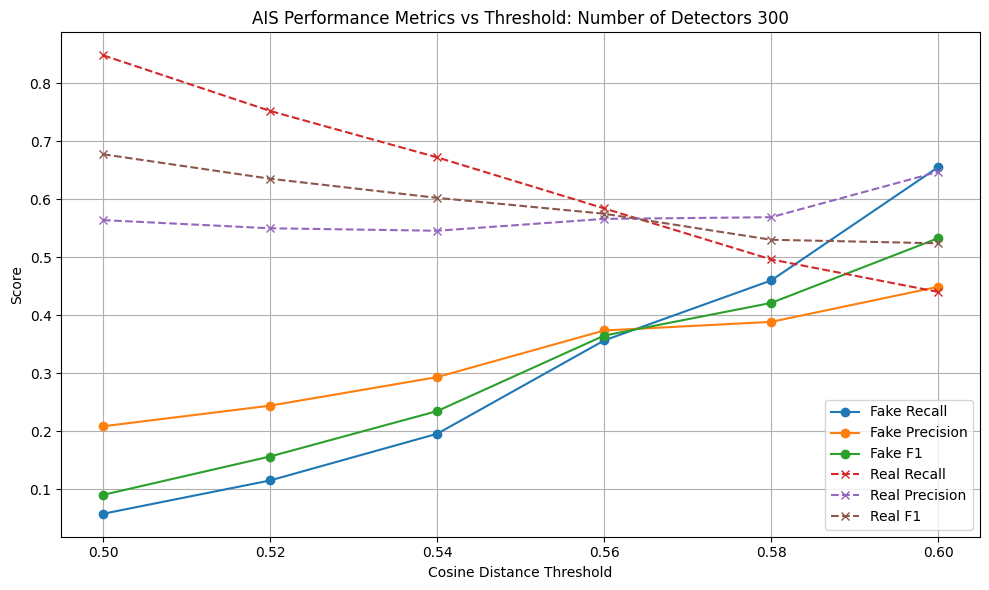

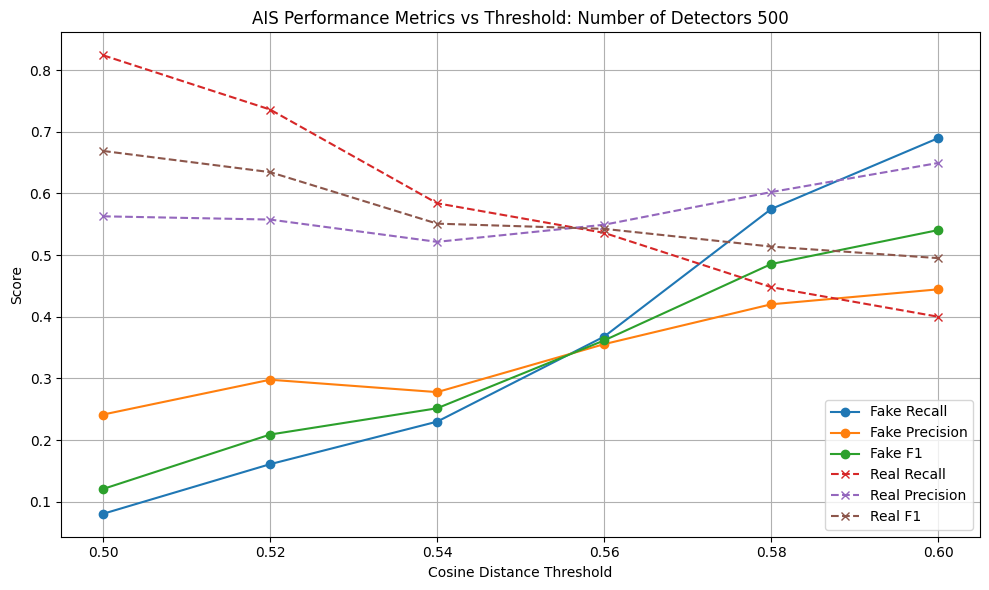

In [18]:
img_path = "/Users/ayeshamendoza/repos/fake-news-immune-system/images"

for num_det in [300, 500]:
    temp_df = df_results[df_results.num_detectors == num_det]
    plt.figure(figsize=(10, 6))

    # Plot fake metrics
    plt.plot(temp_df["threshold"], temp_df["fake_recall"], label="Fake Recall", marker='o')
    plt.plot(temp_df["threshold"], temp_df["fake_precision"], label="Fake Precision", marker='o')
    plt.plot(temp_df["threshold"], temp_df["fake_f1"], label="Fake F1", marker='o')

    # Plot real metrics
    plt.plot(temp_df["threshold"], temp_df["real_recall"], label="Real Recall", marker='x', linestyle='--')
    plt.plot(temp_df["threshold"], temp_df["real_precision"], label="Real Precision", marker='x', linestyle='--')
    plt.plot(temp_df["threshold"], temp_df["real_f1"], label="Real F1", marker='x', linestyle='--')

    # Chart formatting
    plt.title(f"AIS Performance Metrics vs Threshold: Number of Detectors {num_det}")
    plt.xlabel("Cosine Distance Threshold")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(img_path, f"plot_det_{num_det}"))
    plt.show()


### Run Final AIS predictions using `threshold = 0.56`, `num_detectors = 500`

In [26]:
t = 0.56
ais_preds = []
for vec in X_test:
    is_anomaly = detect_anomaly(vec, detectors, threshold=t)
    ais_preds.append(1 if is_anomaly else 0)
    
print(classification_report(y_test, ais_preds, target_names=["REAL", "FAKE"]))

              precision    recall  f1-score   support

        REAL       0.56      0.53      0.54       125
        FAKE       0.37      0.40      0.39        87

    accuracy                           0.48       212
   macro avg       0.47      0.47      0.46       212
weighted avg       0.48      0.48      0.48       212



### ML Classifier (baseline)

In [22]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

ml_preds = clf.predict(X_test)
ml_probs = clf.predict_proba(X_test)[:, 1]
print('ML Model Performance')
print(classification_report(y_test, ml_preds, target_names=['REAL', 'FAKE']))


ML Model Performance
              precision    recall  f1-score   support

        REAL       0.82      0.86      0.84       125
        FAKE       0.78      0.74      0.76        87

    accuracy                           0.81       212
   macro avg       0.80      0.80      0.80       212
weighted avg       0.81      0.81      0.81       212



#### Hybrid Model `AIS + ML`

In [27]:
ais_scores = np.array(ais_preds)
hybrid_scores = 0.4 * ais_scores + 0.6 * ml_probs

threshold = 0.5
hybrid_preds = (hybrid_scores >= threshold).astype(int)

print("Hybrid Model Performance:")
print(classification_report(y_test, hybrid_preds, target_names=["REAL", "FAKE"]))

Hybrid Model Performance:
              precision    recall  f1-score   support

        REAL       0.76      0.77      0.76       125
        FAKE       0.66      0.66      0.66        87

    accuracy                           0.72       212
   macro avg       0.71      0.71      0.71       212
weighted avg       0.72      0.72      0.72       212



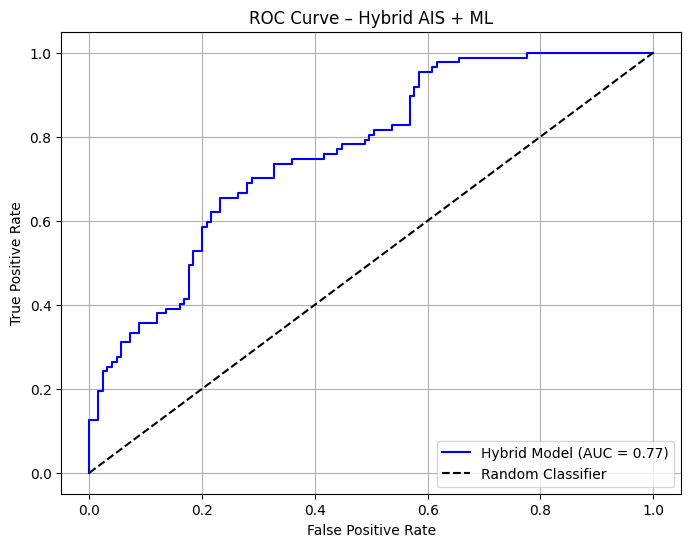

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_test, hybrid_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Hybrid Model (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Hybrid AIS + ML')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [31]:
ais_scores = np.array(ais_preds)
hybrid_scores = 0.3 * ais_scores + 0.7 * ml_probs

threshold = 0.45
hybrid_preds = (hybrid_scores >= threshold).astype(int)

print("Hybrid Model Performance:")
print(classification_report(y_test, hybrid_preds, target_names=["REAL", "FAKE"]))

Hybrid Model Performance:
              precision    recall  f1-score   support

        REAL       0.85      0.74      0.79       125
        FAKE       0.69      0.82      0.75        87

    accuracy                           0.77       212
   macro avg       0.77      0.78      0.77       212
weighted avg       0.79      0.77      0.78       212



In [32]:
ais_scores = np.array(ais_preds)
hybrid_scores = 0.0 * ais_scores + 1.0 * ml_probs

threshold = 0.45
hybrid_preds = (hybrid_scores >= threshold).astype(int)

print("Hybrid Model Performance:")
print(classification_report(y_test, hybrid_preds, target_names=["REAL", "FAKE"]))

Hybrid Model Performance:
              precision    recall  f1-score   support

        REAL       0.84      0.84      0.84       125
        FAKE       0.77      0.77      0.77        87

    accuracy                           0.81       212
   macro avg       0.81      0.81      0.81       212
weighted avg       0.81      0.81      0.81       212

